# Range setting

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import PercentFormatter

In [69]:
# Parameters for normal distribution
mu = -1
sigma = 0.5
param = 35648
x_float = np.random.normal(mu, sigma, param)

mean/mu = -0.9977564607108482 | std/sigma = 0.4990252399214418 


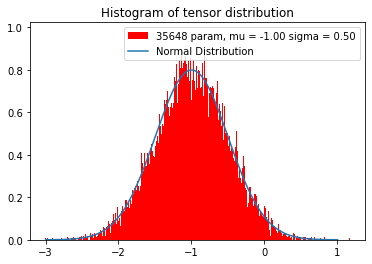

In [70]:

mu = np.mean(x_float)
sigma = np.std(x_float)

print("mean/mu = {} | std/sigma = {} ".format(mu, sigma))

plt.title(label="Histogram of tensor distribution")
plt.hist(x_float, bins=1000, density=True, label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])

# affichage de la courbe de la distribution normale pour comparaison
x = np.linspace(-2+mu,2+mu,1000)
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

plt.plot(x, y, label="Normal Distribution")

plt.legend()
plt.show()


Fake symmetric quantization function

In [71]:
def fake_sym_quant(x_float, M=8, f_max = None, s_sym = None):
    
    a_max  = (pow(2,M-1)) - 1

    if f_max == None:
        f_max  = np.max(np.abs(x_float))

    if s_sym == None:
        s_sym = (f_max)/(a_max)

    x_int = np.clip(np.round(x_float/s_sym), -a_max, a_max)

    x_sym_requant = s_sym*(x_int)

    return x_sym_requant

Fake asymmetric quantization function

In [72]:
def fake_asym_quant(x_float, M=8, f_min_asym = None, f_max_asym = None, s_asym = None):
    a_min_asym  = - pow(2,M-1)
    a_max_asym  = pow(2,M-1) - 1

    if f_min_asym == None or f_max_asym == None :
        f_max_asym  = np.max(x_float)
        f_min_asym = np.min(x_float)

    if s_asym == None :
        s_asym = (f_max_asym - f_min_asym)/(a_max_asym - a_min_asym)

    z_int = - round(f_min_asym/s_asym) + a_min_asym

    x_int_asym = np.clip(np.round(x_float/s_asym)+z_int, a_min_asym, a_max_asym)

    x_asym_requant = s_asym*(x_int_asym-z_int)

    return x_asym_requant

Display error and MSE function

In [83]:
def error_and_MSE (x_float, x_sym_requant, x_asym_requant, label1 = "1rst", label2 = "2nd"):
    
    MSE_sym = ((x_sym_requant - x_float)**2).mean()
    MSE_asym = ((x_asym_requant - x_float)**2).mean()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(x_sym_requant - x_float, label=f"{label1} ; MSE = {MSE_sym:.4E}", bins=1000, color= ['blue'])
    axs[0].legend()
    axs[1].hist(x_asym_requant - x_float, label=f"{label2} ; MSE = {MSE_asym:.4E}", bins=1000, color= ['green'])
    axs[1].legend()
    plt.show()

Choose resolution

In [74]:
M = 8

### Min/max range setting

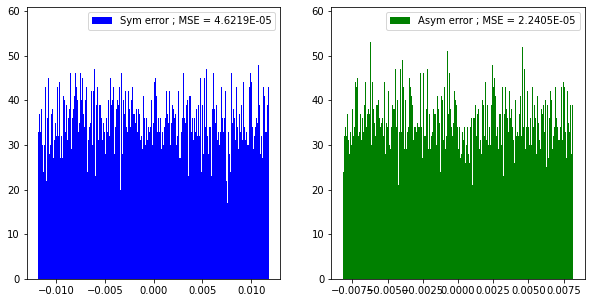

In [75]:
f_max_abs = np.max(np.abs(x_float))
f_max  = np.max(x_float)
f_min = np.min(x_float)
minmax_sym_requant = fake_sym_quant(x_float, M=M, f_max=f_max_abs)
minmax_asym_requant = fake_asym_quant(x_float, M=M, f_min_asym=f_min, f_max_asym=f_max)
error_and_MSE (x_float, minmax_sym_requant, minmax_asym_requant)

### Std based range setting

Original : min : -3.0032703400737177 max : 1.1688313956062855
Std : min : -2.4948321804751736 max : 0.4993192590534772


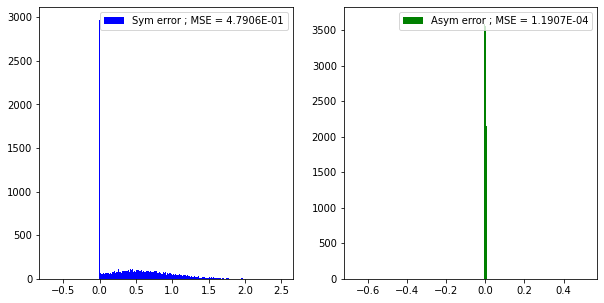

In [76]:
mu = np.mean(x_float)
std = np.std(x_float)
std_factor = 3

f_std_max  = std*std_factor+mu
f_std_min = -std*std_factor+mu
print("Original : min : {} max : {}".format(f_min, f_max))
print("Std : min : {} max : {}".format(f_std_min, f_std_max))
std_sym_requant = fake_sym_quant(x_float, M=M, f_max=f_std_max)
std_asym_requant = fake_asym_quant(x_float, M=M, f_min_asym=f_std_min, f_max_asym=f_std_max)
error_and_MSE (x_float, std_sym_requant, std_asym_requant)

### MSE range setting

Todo : asymmetric

In [77]:
import math

def uniform_quantizer(x, S):
    xQ = np.round(x / S) * S
    return xQ

def SymGaussianClippingAnalysis(x_float, Alpha, sigma,bitWidth):
    Analysis = []
    for alpha in Alpha:
        clipping_mse = (sigma**2 + (alpha ** 2)) * (1 - math.erf(alpha / (sigma*np.sqrt(2.0)))) - np.sqrt(2.0/np.pi) * alpha * sigma*(np.e ** ((-1)*(0.5* (alpha ** 2))/sigma**2))
        quant_mse = (alpha ** 2) / (3 * (2 ** (2 * bitWidth)))
        mse = clipping_mse + quant_mse
        Analysis.append(mse)
    return Analysis

def SymGaussianClippingSimulation(x_float, Alpha, sigma,bitWidth):
    simulations = []
    for alpha in Alpha:
        s = np.copy(x_float)
        S = (2*alpha)/(2**bitWidth)
        # clipping
        s[s > alpha] = alpha
        s[s < -alpha] = -alpha
        # quabtization
        s = uniform_quantizer(s, S)

        mse = ((s - x_float) ** 2).mean()
        simulations.append(mse)
    return simulations

Finding the best alpha for clipping

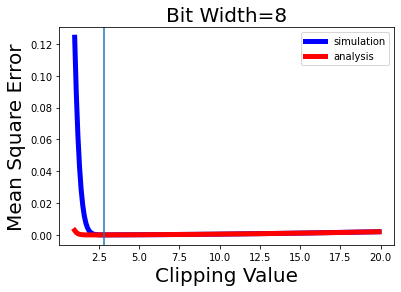

In [78]:
Alpha = np.arange(1, 20, 0.1)
std = np.std(x_float)

simulation = SymGaussianClippingSimulation(x_float, Alpha, std, M)
analysis = SymGaussianClippingAnalysis(x_float, Alpha, std, M)

plt.plot(Alpha,simulation,'b', linewidth=5)
plt.plot(Alpha,analysis,'r', linewidth=5)
plt.legend(('simulation', 'analysis')); plt.ylabel('Mean Square Error', size=20) ; plt.xlabel('Clipping Value', size=20)
plt.axvline(x = Alpha[np.argmin(simulation)], label="lower value")
plt.title('Bit Width='+ str(M), size=20)
plt.show()


Taking the best alpha

Original : min : -3.0032703400737177 max : 1.1688313956062855
Std : min : -0.021875000000000012 max : 0.021875000000000012


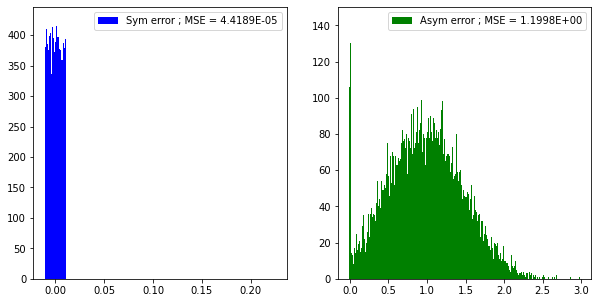

In [79]:
winner_alpha = Alpha[np.argmin(simulation)] 
S = (2*winner_alpha)/(2**M)
f_mse_min = -(2*winner_alpha)/(2**M) # to do for asymetric
f_mse_max = (2*winner_alpha)/(2**M)
print("Original : min : {} max : {}".format(f_min, f_max))
print("Std : min : {} max : {}".format(f_mse_min, f_mse_max))
mse_sym_requant = fake_sym_quant(x_float, M=M, f_max=f_mse_max, s_sym = S)
mse_asym_requant = fake_asym_quant(x_float, M=M, f_min_asym=f_mse_min, f_max_asym=f_mse_max, s_asym = S) # to do : asymetric
error_and_MSE (x_float, mse_sym_requant, mse_asym_requant)

Cross entropy for last layer (logits)

To do !

Compare all methods :

In [80]:
def MSE_compute(x, y): 
 return ((y - x)**2).mean()

In [81]:
MSE_minmax_sym = MSE_compute( minmax_sym_requant , x_float)
MSE_minmax_asym = MSE_compute( minmax_asym_requant , x_float)

print("Minmax")
print(" symmetric : ", MSE_minmax_sym,"asymmetric : ", MSE_minmax_asym)

MSE_std_sym = MSE_compute( std_sym_requant , x_float)
MSE_std_asym = MSE_compute( std_asym_requant , x_float)

print("std")
print(" symmetric : ", MSE_std_sym,"asymmetric : ", MSE_std_asym)

MSE_mse_sym = MSE_compute( mse_sym_requant , x_float)
MSE_mse_asym = MSE_compute( mse_asym_requant , x_float)

print("MSE asym not done")
print(" symmetric : ", MSE_mse_sym,"asymmetric : ", MSE_mse_asym)

Minmax
 symmetric :  4.6219273715204825e-05 asymmetric :  2.240474938506744e-05
std
 symmetric :  0.4790582845894195 asymmetric :  0.00011906828509904292
MSE asym not done
 symmetric :  4.4189192115553575e-05 asymmetric :  1.1997936290192208


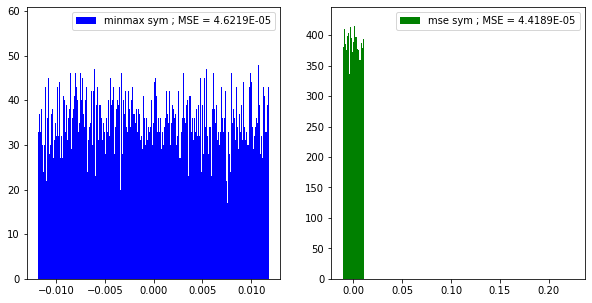

In [84]:
error_and_MSE (x_float, minmax_sym_requant, mse_sym_requant, label1="minmax sym", label2="mse sym")